# Mouse Atlas Review

This Jupyter notebook is designed to perform a comprehensive analysis of the atlas generated in the study “Mouse pancreatic islet scRNA-seq atlas across sexes, ages, and stress conditions including diabetes” by Hrovatin et al. (2022).

**This notebook includes:**
- Data extraction and analysis, replicating selected procedures from the original study along with new analyses.
- Machine learning models to predict diabetes-related cell states based on gene expression data.

In [1]:
!pip install scrublet

In [2]:
# Libraries needed

import scanpy as sc
import pandas as pd
import pickle
import datetime
import os
import numpy as np
import json
from scipy import sparse
import scrublet as scr

#import scarches as sca

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib import colors as mcolors


Access the files

In [3]:
# --------------------------------------------------
# Path configuration (repository-relative)
# --------------------------------------------------

from pathlib import Path

# Root of the repository
# Assumes this notebook is run from the `code/` directory
REPO_ROOT = Path.cwd().parent

# --------------------------------------------------
# Data directories
# --------------------------------------------------

DATA_DIR = REPO_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
OUTPUTS_DIR = DATA_DIR / "outputs"

# Create output directories if they do not exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# Mouse Islet Atlas (raw data, NOT versioned)
# --------------------------------------------------
# The atlas must be downloaded from:
# https://cellxgene.cziscience.com/collections/296237e2-393d-4e31-b590-b03f74ac5070
#
# and placed inside:
# data/raw/

EXPECTED_ATLAS = RAW_DATA_DIR / "mouse_islet_atlas.h5ad"

# Handle UUID-based filenames automatically
if EXPECTED_ATLAS.exists():
    ATLAS = EXPECTED_ATLAS
else:
    h5ad_files = list(RAW_DATA_DIR.glob("*.h5ad"))
    if len(h5ad_files) == 1:
        ATLAS = h5ad_files[0]
        print(f"Using downloaded atlas file: {ATLAS.name}")
    else:
        raise FileNotFoundError(
            "Mouse Islet Atlas not found. Please download the .h5ad file from "
            "cellxgene and place it in data/raw/."
        )

# --------------------------------------------------
# Auxiliary files from the original Hrovatin et al. repository
# (NOT versioned)
# --------------------------------------------------

AUX_DATA_DIR = REPO_ROOT / "hrovatin_paper_code_and_data_analysis"

QUERY_DATA = AUX_DATA_DIR / "adata_query.h5ad"
REFERENCE_DATA = AUX_DATA_DIR / "adata_ref.h5ad"
REFERENCE_SUBSET = AUX_DATA_DIR / "adata_ref_latent.h5ad"

PARAMETERS = AUX_DATA_DIR / "params.pkl"
GENES = AUX_DATA_DIR / "scArches.json"

# --------------------------------------------------
# Sanity checks
# --------------------------------------------------

paths = {
    "ATLAS (raw)": ATLAS,
    "QUERY_DATA": QUERY_DATA,
    "REFERENCE_DATA": REFERENCE_DATA,
    "REFERENCE_SUBSET": REFERENCE_SUBSET,
    "PARAMETERS": PARAMETERS,
    "GENES": GENES,
}

for name, path in paths.items():
    print(f"{name}: {path}")
    print(f"  Exists: {path.exists()}\n")

Using downloaded atlas file: 49243c50-bf0c-4b10-87f8-55ec9f455399.h5ad
ATLAS (raw): /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/data/raw/49243c50-bf0c-4b10-87f8-55ec9f455399.h5ad
  Exists: True

QUERY_DATA: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/hrovatin_paper_code_and_data_analysis/adata_query.h5ad
  Exists: True

REFERENCE_DATA: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/hrovatin_paper_code_and_data_analysis/adata_ref.h5ad
  Exists: True

REFERENCE_SUBSET: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/hrovatin_paper_code_and_data_analysis/adata_ref_latent.h5ad
  Exists: True

PARAMETERS: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/hrovatin_paper_code_and_data_analysis/params.pkl
  Exists: True

GENES: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/hrovatin_paper_code_and_data_analysis/scArches.json
  Exists: True



### Query data* (extracted from the original paper)
We recomend use of UMI-based scRNA-seq queries (query mapping was not tested on full-length scRNA-seq datasets). Query data (saved in AnnData h5ad format) should contain normalised expression in X (per-sample normalisation with Scran followed by log(x+1) transformation). Genes should be specified as Ensembl IDs in var_names. Each sample should be one batch, here we specify it in obs column batch_integration.

 ### Model parameters
Prepare parameters that were used in the reference model.

In [4]:
# Load parameters of the reference model
params=pickle.load(open(PARAMETERS,'rb'))
print('Reference params:',params)

Reference params: {'z_dimension': 15, 'architecture': [128, 128, 128], 'task_name': 'run_scArches1603792372.695119', 'x_dimension': 2000, 'beta': 0.0, 'alpha': 0.99, 'loss_fn': 'sse', 'n_epochs': 150, 'batch_size': 128, 'subset_beta': False, 'hvg_n': '2000', 'input_file_name': 'data_normlisedForIntegration.h5ad'}


Load the Atlas, reference data and query for re-loading of the model.

In [5]:
#Load the Atlas
adata_ref_latent = sc.read(ATLAS)
adata_ref_latent
# Load the reference data (to reload the model)
adata_ref=sc.read(REFERENCE_DATA)
adata_ref
# Load query data
adata_query=sc.read(QUERY_DATA)
adata_query

AnnData object with n_obs × n_vars = 2741 × 1988
    obs: 'strain', 'STZ', 'insulin_implant', 'time_after_STZ', 'age', 'batch', 'cell_type_original', 'cell_subtype_original', 'cell_type', 'donor', 'sex', 'disease', 'size_factors', 'batch_integration'
    var: 'gene_symbol'

Prepare features (genes) in accordance with the pre-trained scArches model.

In [6]:
# Genes used in the model
used_genes=json.load(open(GENES,'r'))['gene_names']
# Subset reference data to the used genes and re-order gene names as used in the model
eid_map=dict(zip(adata_ref.var.gene_symbol_original_matched,adata_ref.var_names))
used_eids=[eid_map[g] for g in used_genes]
adata_ref=adata_ref[:,used_eids]
adata_ref

View of AnnData object with n_obs × n_vars = 0 × 2000
    obs: 'batch_integration'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'

In the original notebook, scArches was used to restore the reference model. Since the replication was done on a local computer, using IOs, the scarches library was not able to be imported to be used with the sistem, due to software limitations and the use of said library and code related  was omited. 

## Query data adapted from the original paper's github

The code below performs the integration and visualization of two single-cell datasets: a reference (`ref`) and a query (`query`). The main steps include:

1. **Concatenation**: Combines the reference and query `AnnData` objects into one, labeling cells by origin (`ref_query`).
2. **Neighbor Graph & UMAP**: Calculates the neighborhood graph and projects the data into 2D using UMAP for visualization.
3. **Color Mapping**: Assigns unique colors to each cell type for consistent visualization across both datasets.
4. **Visualization**: Generates two side-by-side UMAP plots—one for the query cells and one for the reference cells—colored by cell type.

This allows direct comparison of cell type distributions and embeddings between the two datasets.

In [7]:
# Remap query features (genes) to match the reference model

# Map from query to integration space
vals=[]
rows=[]
cols=[]
eid_mm_map=dict(zip(adata_ref.var_names,range(adata_ref.shape[1])))
for row,eid_mm in enumerate(adata_query.var_names):
    if eid_mm in eid_mm_map:
        col=eid_mm_map[eid_mm]
        vals.append(1)
        rows.append(row)
        cols.append(col)
gene_inetgration_map=sparse.csr_matrix(
    (np.array(vals), (np.array(rows), np.array(cols))), 
    shape=(adata_query.shape[1], adata_ref.shape[1]))

# Subset data to query genes
adata_query=sc.AnnData(
    sparse.csr_matrix(adata_query.X)@gene_inetgration_map,
    obs=adata_query.obs,
    var=adata_ref.var[['gene_symbol', 'used_integration', 'gene_symbol_original_matched']])
adata_query.X = np.asarray(adata_query.X.todense())
print('Integration data shape:',adata_query.shape) 

Integration data shape: (2741, 2000)


/var/folders/19/d97czy951sb67yv3hd9974780000gn/T/ipykernel_78054/3204899528.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  latent = sc.AnnData.concatenate(
/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


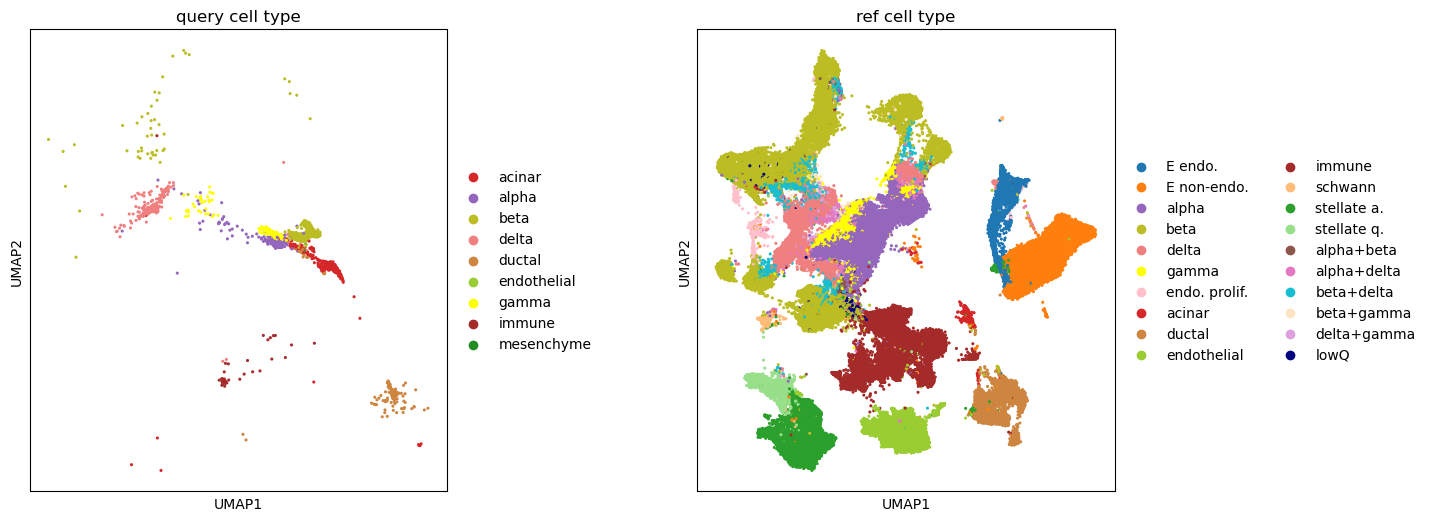

In [8]:
# Concatenate
latent = sc.AnnData.concatenate(
    adata_ref_latent, adata_query,
    batch_key='ref_query',
    batch_categories=['ref','query']
)

# Compute neighbors + UMAP
sc.pp.neighbors(latent, use_rep='X')
sc.tl.umap(latent)

# Cell types
REF_COL   = 'cell_type_reannotatedIntegrated'   
QUERY_COL = 'cell_type'                         

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown',
          'tab:pink','tab:olive','tab:cyan','bisque','limegreen','lightcoral','plum',
          'peru','pink','yellowgreen','paleturquoise','yellow','gold','brown','navy',
          'forestgreen','lime','lightsalmon','teal','olive']

# Present categories
ref_cats = pd.Index(latent.obs[REF_COL].astype('category').cat.categories) if REF_COL in latent.obs else pd.Index([])
qry_cats = pd.Index(latent.obs[QUERY_COL].astype('category').cat.categories) if QUERY_COL in latent.obs else pd.Index([])
all_cats = ref_cats.union(qry_cats)

# Ensure enough colors
if len(colors) < len(all_cats):
    extra = [mcolors.to_hex(cm.tab20(i % 20)) for i in range(len(all_cats) - len(colors))]
    colors = list(colors) + extra

ct_cmap = dict(zip(all_cats, colors))

if REF_COL in latent.obs:
    latent.uns[f'{REF_COL}_colors'] = [ct_cmap[c] for c in ref_cats]
if QUERY_COL in latent.obs:
    latent.uns[f'{QUERY_COL}_colors'] = [ct_cmap[c] for c in qry_cats]
    
# Plot ref vs query
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Query
sc.pl.umap(latent[latent.obs.ref_query=='query', :],
           color=QUERY_COL, ax=axs[0], show=False, s=20, title='query cell type')

# Ref
sc.pl.umap(latent[latent.obs.ref_query=='ref', :],
           color=REF_COL, ax=axs[1], show=False, s=20, title='ref cell type')

plt.subplots_adjust(wspace=0.6)
plt.show()

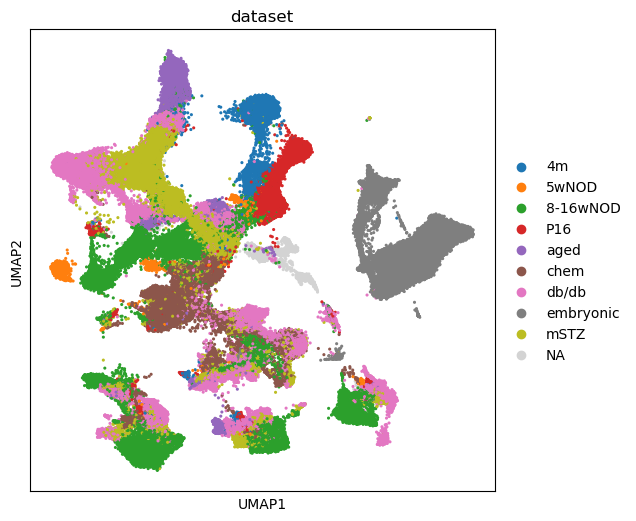

In [9]:
DATASET_COL = 'dataset'
REF_FLAG    = 'ref_query'

latent.obs[DATASET_COL] = latent.obs[DATASET_COL].astype('category')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.umap(latent, color=DATASET_COL, ax=ax, show=False, s=20, title='dataset')
plt.show()

## Cell Analysis

Before applying Machine Learning models, it is important to undestand the dataset at is fullest, so a complete analysis needs to be performed, with focus on T2D and Normal Cells.

To do that, we start by listing all variables

In [10]:
import anndata as ad
anns = {k:v for k,v in globals().items() if isinstance(v, ad.AnnData)}
anns

{'_': View of AnnData object with n_obs × n_vars = 0 × 2000
     obs: 'batch_integration'
     var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched',
 '__': AnnData object with n_obs × n_vars = 2741 × 1988
     obs: 'strain', 'STZ', 'insulin_implant', 'time_after_STZ', 'age', 'batch', 'cell_type_original', 'cell_subtype_original', 'cell_type', 'donor', 'sex', 'disease', 'size_factors', 'batch_integration'
     var: 'gene_symbol',
 'adata_ref_latent': AnnData object with n_obs × n_vars = 301796 × 30849
     obs: 'batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample', 'cell_subtype_immune_reannotatedIntegrated', 'cell_subtype_endothelial_reannotatedIntegrated', 'emptyDrops_LogProb_sca

Now we identify the number of cells per dataset and per disease, to later work only on the filtered data

In [11]:
obs = latent.obs.copy()

pivot_counts = pd.crosstab(
    index=obs['dataset'],
    columns=obs['disease'],
    dropna=False,
    margins=True,              
    margins_name='Total'       
).fillna(0).astype(int)

pivot_counts

disease,T2D,endocrine pancreas disorder,healthy,normal,type 1 diabetes mellitus,type 2 diabetes mellitus,Total
dataset,,,,,,,
NaN,1731,0,1010,0,0,0,0
4m,0,0,0,17353,0,0,17353
5wNOD,0,0,0,2690,0,0,2690
8-16wNOD,0,0,0,14397,39932,0,54329
P16,0,0,0,19881,0,0,19881
aged,0,0,0,17361,0,0,17361
chem,0,27527,0,5804,0,0,33331
db/db,0,0,0,11155,0,58590,69745
embryonic,0,0,0,37561,0,0,37561


After reviewing the datasets, we decided to exclude embryonic, chem, and 8–16wNOD datasets from the analysis, in order to focus only on adult cells; normal and diabetic.

To reduce computational workload, we created a filtered subset called `latent_sel`, which will be used for downstream analysis.

In [12]:
DISEASE_COL = 'disease'
DATASET_COL = 'dataset'
REF_COL     = 'cell_type_reannotatedIntegrated'
QUERY_COL   = 'cell_type'   # fallback

# Checks
for col in [DISEASE_COL, DATASET_COL]:
    if col not in latent.obs.columns:
        raise KeyError(f"Column '{col}' not found in latent.obs")

# Clean text and build masks
obs = latent.obs.copy()

disease_clean = (obs[DISEASE_COL].astype(str)
                 .str.strip().str.lower().str.replace(r'\s+', ' ', regex=True))
keep_diseases = {'type 2 diabetes mellitus', 'normal'}
mask_disease  = disease_clean.isin(keep_diseases)

dataset_clean = (obs[DATASET_COL].astype(str)
                 .str.strip().str.lower())
exclude_datasets = {'chem', '8-16wnod', 'embryonic'}
mask_dataset = ~dataset_clean.isin(exclude_datasets)

mask = mask_disease & mask_dataset

# Subset
latent_sel = latent[mask].copy()

# oloring column for later convenience
color_col = REF_COL if REF_COL in latent_sel.obs.columns else QUERY_COL

print("Original shape:", latent.shape, "(cells x genes)")
print("Subset   shape:", latent_sel.shape)
print("Color column:", color_col)

# UMAP for quick future plotting
if 'X_umap' not in latent_sel.obsm_keys():
    sc.pp.neighbors(latent_sel, use_rep='X')   # change if you use another embedding
    sc.tl.umap(latent_sel)

Original shape: (304537, 1997) (cells x genes)
Subset   shape: (176575, 1997)
Color column: cell_type_reannotatedIntegrated


We cluster and normalize over the filtered cells

In [13]:
from statsmodels.robust.scale import mad

sc.settings.verbosity = 2
sc.settings.set_figure_params(figsize=(4,4), dpi=100)

# Base object: use the integrated atlas in memory if available
try:
    A0 = latent_sel
    print("Using in-memory object `latent_sel`.")
except NameError:
    raise NameError("The variable `latent_sel` was not found. Please load your atlas and assign it to `latent`.")

adata = A0.copy()
adata


Using in-memory object `latent_sel`.


AnnData object with n_obs × n_vars = 176575 × 1997
    obs: 'batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample', 'cell_subtype_immune_reannotatedIntegrated', 'cell_subtype_endothelial_reannotatedIntegrated', 'emptyDrops_LogProb_scaled', 'cell_subtype_beta_coarse_reannotatedIntegrated', 'cell_subtype_beta_fine_reannotatedIntegrated', 'GP_1', 'GP_2', 'GP_3', 'GP_4', 'GP_5', 'GP_6', 'GP_7', 'GP_8', 'GP_9', 'GP_10', 'GP_11', 'GP_12', 'GP_13', 'GP_14', 'GP_15', 'GP_16', 'GP_17', 'GP_18', 'GP_19', 'GP_20', 'GP_21', 'GP_22', 'GP_23', 'GP_24', 'GP_25', 'GP_26', 'GP_27', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'diabetes_model', 'chemical_stress', 'GEO_

## Quality Control (QC) Pipeline for scRNA-seq Data

This section defines and applies quality control (QC) thresholds to remove low-quality cells from the dataset.

### QC Parameters
We define all QC thresholds in a centralized dictionary (`QC_PARAMS`), making it easy to adjust and iterate. Each entry specifies:
- the QC variable to evaluate (e.g., `% mitochondrial counts`, total counts),
- the filtering method (`percentile`, `mad`, or `range`),
- the upper and/or lower threshold.

Thresholds can be easily modified by editing the `QC_PARAMS` dictionary.

### Gene Flags and Basic Metrics
We compute basic QC metrics using `scanpy`, including:
- Percentage of mitochondrial genes (`pct_counts_mt`)
- Total counts per cell
- Number of genes per cell


In [14]:
# mt_frac is 0–1; convert to %
adata.obs['pct_counts_mt'] = adata.obs['mt_frac'] * 100

# For log10_n_counts, recover total_counts
adata.obs['total_counts'] = 10 ** adata.obs['log10_n_counts']

# n_genes already exists
adata.obs['n_genes_by_counts'] = adata.obs['n_genes']

for col in ['pct_counts_mt','n_genes_by_counts', 'total_counts']:
    print(col, adata.obs[col].describe(), '\n')

pct_counts_mt count    176575.000000
mean          3.679176
std           2.346273
min           0.000000
25%           2.191412
50%           3.010832
75%           4.394876
max          21.833897
Name: pct_counts_mt, dtype: float64 

n_genes_by_counts count    176575.000000
mean       3053.597559
std        1384.632133
min         350.000000
25%        2051.000000
50%        3034.000000
75%        3997.000000
max        9644.000000
Name: n_genes_by_counts, dtype: float64 

total_counts count    176575.000000
mean      21831.583957
std       18895.511385
min         859.000269
25%        7784.003096
50%       16848.013429
75%       31209.502807
max      262387.112341
Name: total_counts, dtype: float64 



In [15]:
# Helper to show counts after every step
def _debug_print(step, mask, total):
    print(f"{step:<25}  kept = {mask.sum():>8} / {total}")

# Robust cutoff helper
def adaptive_cut(arr, k=3.0):
    return np.median(arr) + k * mad(arr, c=1.4826)

# Main filtering function with verbose output
def per_batch_keep_debug(obs: pd.DataFrame, batch_key=None, k=3.0):
    """Return boolean mask of cells to keep, printing diagnostics."""
    keep_global = pd.Series(False, index=obs.index)  # init

    groups = [(None, obs.index)] if batch_key is None else obs.groupby(batch_key).groups.items()
    for b, idx in groups:
        sub  = obs.loc[idx]
        totN = len(sub)

        print(f"\n=== Batch {b}  (cells = {totN}) ===")

        # start with all True for this batch
        mask = pd.Series(True, index=sub.index)

        mt_cut = adaptive_cut(sub['pct_counts_mt'], k)
        mask_mt = sub['pct_counts_mt'] < mt_cut
        _debug_print(f"pct_counts_mt < {mt_cut:.2f}", mask_mt, totN)
        mask &= mask_mt

        ncut   = sub['n_genes_by_counts'].quantile(0.99)
        mask_ng = sub['n_genes_by_counts'] < ncut
        _debug_print(f"n_genes < {ncut:.0f}", mask_ng, totN)
        mask &= mask_ng

        ccut   = sub['total_counts'].quantile(0.99)
        mask_tc = sub['total_counts'] < ccut
        _debug_print(f"total_counts < {ccut:.0f}", mask_tc, totN)
        mask &= mask_tc

        _debug_print("after all rules", mask, totN)

        keep_global.loc[idx] = mask

    print(f"\n=== Overall kept: {keep_global.sum()} / {len(obs)} ===")
    return keep_global

batch_key = 'batch_integration' if 'batch_integration' in adata.obs.columns else None
keep_cells = per_batch_keep_debug(adata.obs, batch_key)

print("\nFiltered AnnData:")
print(f"  cells kept: {keep_cells.sum()} / {adata.n_obs}")
adata = adata[keep_cells].copy()


=== Batch Fltp_2y_MUC13974  (cells = 7534) ===
pct_counts_mt < 7.54       kept =     6070 / 7534
n_genes < 6509             kept =     7458 / 7534
total_counts < 83242       kept =     7458 / 7534
after all rules            kept =     5966 / 7534

=== Batch Fltp_2y_MUC13975  (cells = 3746) ===
pct_counts_mt < 5.48       kept =     3041 / 3746
n_genes < 6994             kept =     3708 / 3746
total_counts < 91226       kept =     3708 / 3746
after all rules            kept =     2993 / 3746

=== Batch Fltp_2y_MUC13976  (cells = 6081) ===
pct_counts_mt < 8.65       kept =     4946 / 6081
n_genes < 6731             kept =     6020 / 6081
total_counts < 96743       kept =     6020 / 6081
after all rules            kept =     4869 / 6081

=== Batch Fltp_P16_145_mGFP  (cells = 9221) ===
pct_counts_mt < 3.21       kept =     8003 / 9221
n_genes < 4890             kept =     9128 / 9221
total_counts < 34746       kept =     9128 / 9221
after all rules            kept =     7868 / 9221

=== Ba

/var/folders/19/d97czy951sb67yv3hd9974780000gn/T/ipykernel_78054/891020903.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [(None, obs.index)] if batch_key is None else obs.groupby(batch_key).groups.items()


## Doublet detection (Scrublet)

In [16]:
!pip install scrublet

In [17]:
# Scrublet expects dense or csr counts (pre-normalization is fine; Scrublet uses raw-like counts, but here we run on X).
X = adata.X.toarray() if sparse.issparse(adata.X) else adata.X
scrub = scr.Scrublet(X, expected_doublet_rate=0.15)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['doublet_score'] = doublet_scores

# Conservative threshold (95th percentile); adjust after inspection
thr = np.quantile(doublet_scores, 0.95)
adata.obs['predicted_doublet'] = adata.obs['doublet_score'] > thr
print("Doublets flagged:", int(adata.obs['predicted_doublet'].sum()))

adata = adata[~adata.obs['predicted_doublet']].copy()


Preprocessing...


/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/scrublet/helper_functions.py:251: RuntimeWarning: invalid value encountered in sqrt
  CV_eff = np.sqrt((1+a)*(1+b) - 1);
/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 4.2%
Estimated detectable doublet fraction = 68.1%
Overall doublet rate:
	Expected   = 15.0%
	Estimated  = 6.2%
Elapsed time: 232.4 seconds
Doublets flagged: 6992


A quick Scrublet run on the QC-filtered atlas subset produced a single narrow peak of scores around 0 and no cells exceeded even a very permissive 95-th percentile cut-off.  
In other words, **this simple check did _not_ detect additional doublets** in the working copy of the atlas.

> _Why is that expected?_  
> The original **Mouse cross-condition pancreatic-islet atlas** already applied doublet removal **per sample** before integration:

* *“Doublets were filtered out with Scrublet (v 0.2.1) scores computed per sample using a manually set threshold … while ensuring that selected doublet cells mainly mapped into discrete cluster locations on the UMAP embedding.”*   
* The authors note that they set this threshold **“permissively, as indicated by the presence of some residual doublet populations in the final atlas version.”*   
* During later re-annotation they again compared Scrublet scores with expected multiplet rates **to distinguish real cell types from residual multiplets**.   

Given that sample-level Scrublet filtering is part of the published pipeline, and that our spot-check found no obvious high-score tail, **we keep the atlas as provided and proceed without an additional doublet removal step.**  
If a stricter policy is required for a downstream analysis, one can revisit Scrublet on raw counts or complement it with an orthogonal tool (e.g. DoubletFinder) using the same per-sample strategy described in the paper.

## Normalization

In [18]:
def is_log_transformed(X):
    """Return True if values look like log1p counts."""
    X = X.A if sparse.issparse(X) else X
    # crude heuristics: non-integers & max <~15
    return (not np.allclose(X, np.rint(X))) and X.max() < 20

def qc_expression(adata):
    X = adata.X.A if sparse.issparse(adata.X) else adata.X
    print("matrix dtype:", adata.X.dtype,
          "| min:", X.min(), "max:", X.max(),
          "| looks log-transformed:", is_log_transformed(adata.X))
    # show a few cells / genes
    df = pd.DataFrame(X[:5, :5])
    display(df)

qc_expression(adata_query)         

matrix dtype: float64 | min: 0.0 max: 11.290863289954725 | looks log-transformed: True


,0,1,2,3,4
0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,2.395631
2,0.000000,0.0,0.000000,0.746753,0.746753
3,0.541328,0.0,3.263468,0.000000,0.000000
4,0.000000,0.0,0.467577,0.000000,0.784926


### Log-normalization check

As stated in the original Mouse Islet Atlas publication, the dataset was already **scran-normalized, log-transformed (log(expr + 1)) and re-scaled** before being made available for download. This preprocessing was performed upstream and used consistently in their downstream analyses.

To validate this, a quick check was performed using a heuristic function that confirms whether the matrix values are likely log-transformed. For `adata_query`, the matrix:
- has `float64` values
- includes non-integers
- shows a max value around 11
- is consistent with a log1p transformation

Because of this, we **skip additional normalization and log1p transformation**, and proceed directly with the selection of highly variable genes (HVGs).
Because of that we **skip another round of `normalize_total`/`log1p`** and proceed directly to selecting highly-variable genes (HVGs). 

## Selection of highly variable genes (HVGs) & Principal Component Analysis (PCA)

extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, returning all genes.
`n_top_genes` > `adata.n_var`, 

/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:07)


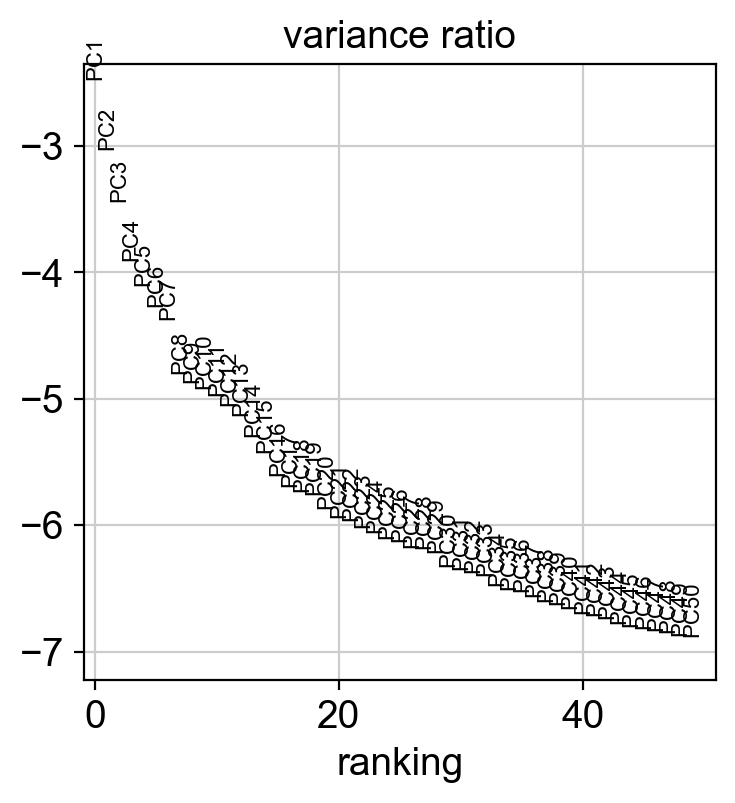

In [19]:
### 0.  Choose the object to analyse
adata_work = adata        # ← or adata, adata_query latent_sel, …

batch_key = 'batch_integration' if 'batch_integration' in adata_work.obs else None

### 1.  Highly variable genes (HVGs)

# We skip `normalize_total` and `log1p` because the atlas is already log-scaled
# Use 'cell_ranger' flavour – no extra dependencies
hvg_kwargs = dict(flavor='cell_ranger', n_top_genes=2000)
if batch_key is not None:
    hvg_kwargs['batch_key'] = batch_key

sc.pp.highly_variable_genes(adata_work, **hvg_kwargs)

# Remove ambient-known genes from the HVG set
if 'ambient_known' in adata_work.var:
    adata_work.var['hvg_final'] = adata_work.var['highly_variable'] & (~adata_work.var['ambient_known'])
else:
    adata_work.var['hvg_final'] = adata_work.var['highly_variable']

print(
    f"HVGs pre-filter : {adata_work.var['highly_variable'].sum():>5d}\n"
    f"HVGs final      : {adata_work.var['hvg_final'].sum():>5d}"
)

# Subset to the final HVG matrix
adata_hvg = adata_work[:, adata_work.var['hvg_final']].copy()

### 2.  Regress technical covariates & scale
covars = [c for c in ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
          if c in adata_hvg.obs]

print("Regressing:", covars if covars else "none")
if covars:
    sc.pp.regress_out(adata_hvg, keys=covars)

sc.pp.scale(adata_hvg, max_value=10)

### 3.  PCA
sc.tl.pca(adata_hvg, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_hvg, log=True, n_pcs=50)


### Selection of Highly Variable Genes (HVGs)

To reduce noise and focus on the most informative features for downstream analysis, highly variable genes (HVGs) were selected using the `seurat_v3` flavor of Scanpy’s `highly_variable_genes` function. We initially requested 2,000 HVGs across batches, but due to the limited number of genes available after filtering, all genes were retained in some batches (`n_top_genes > adata.n_var`), as indicated by the warnings.

Additionally, known ambient genes were excluded from the set of HVGs using an internal annotation (`adata.var['ambient_known']`). This resulted in a final set of 1,998 HVGs, which were used to subset the dataset for normalization and dimensionality reduction.

Before PCA, we regressed out two technical covariates: **total UMI counts per cell** and **percentage of mitochondrial gene expression**, which can introduce unwanted variance. The data was subsequently scaled and centered with a maximum value of 10 to stabilize variance across genes.


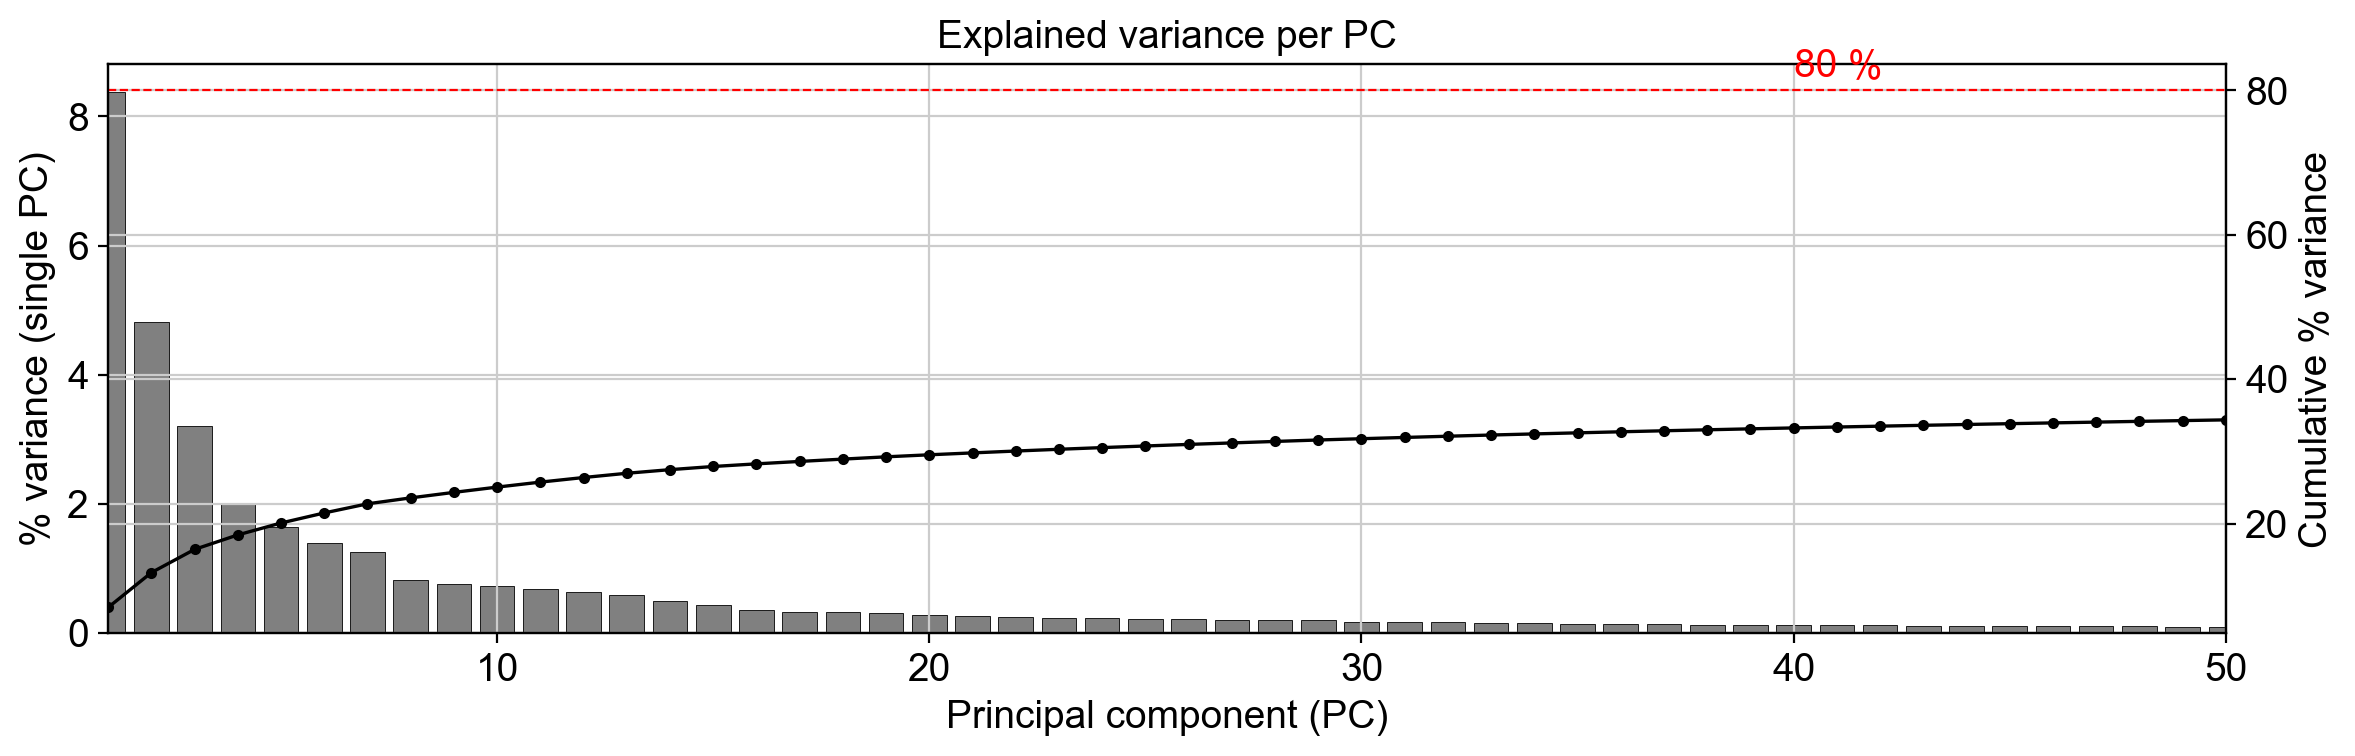

In [20]:
# 1) fetch the explained‐variance ratio from the PCA that is stored in .uns
var_ratio = adata_hvg.uns["pca"]["variance_ratio"]      # length = n_pcs you asked for
pcs        = np.arange(1, len(var_ratio) + 1)

# 2) cumulative variance for context
cum_var = np.cumsum(var_ratio)

# 3) make a wider figure
plt.figure(figsize=(12, 4))                            # width, height in inches

# left Y-axis: individual PCs (bars)
plt.bar(pcs, var_ratio * 100, color="grey", edgecolor="black", linewidth=0.3)
plt.xlabel("Principal component (PC)")
plt.ylabel("% variance (single PC)")

# right Y-axis: cumulative curve
plt.twinx()
plt.plot(pcs, cum_var * 100, color="black", lw=1.2, marker="o", ms=3)
plt.ylabel("Cumulative % variance")

# draw a horizontal line at 80 % to help choose a cut-off
plt.axhline(80, ls="--", color="red", lw=0.8)
plt.text(len(pcs) - 10, 82, "80 %", color="red")

plt.title("Explained variance per PC")
plt.xlim(1, len(pcs))
plt.tight_layout()
plt.show()

### Principal Component Analysis (PCA)

PCA was computed using the filtered and scaled HVG matrix. The explained variance ratio per principal component (PC) showed that:

- **PC1 captured ~4.5%** of the total variance.
- **PC2 and PC3** explained progressively less, with the variance tailing off after PC10.
- The **elbow point** in the cumulative variance curve was reached around **PC15–20**, indicating a natural cut-off for selecting dimensions for downstream tasks.

To balance signal retention with dimensionality reduction, we selected the **first 25 PCs** for constructing the neighborhood graph and computing UMAP embeddings. This number captures a substantial portion of the variance while avoiding overfitting to noise in the data.


# Differential Expression (DE) and GO enrichment for β-cells: T2D vs Healthy

**Aim.** Having performed diabetes-aware QC and clustering, we now focus on **β-cells** and test for
transcriptional differences between **T2D** and **Healthy** cells, followed by **functional enrichment**
to interpret the biology (e.g. ER stress/UPR, loss of β-cell identity).

**Design choices**
- Use **Wilcoxon rank-sum** (`scanpy.tl.rank_genes_groups`) on the β-cell subset.
- Export a tidy DE table for T2D vs Healthy.
- Perform **GO Biological Process** enrichment (via `gseapy.enrichr`). If `gseapy` is not available, the step is skipped gracefully.
- Provide volcano plot and bar chart of top enriched terms.


In [21]:
OUT = OUTPUTS_DIR / "diabetes_vs_healthy_outputs"
OUT.mkdir(parents=True, exist_ok=True)

# Reuse objects created earlier
try:
    adata  # processed AnnData (diabetes-aware)
except NameError:
    raise NameError("The variable `adata` was not found. Run the QC/normalization section first.")

# Ensure the healthy_vs_T2D label exists
if 'healthy_vs_T2D' not in adata.obs.columns:
    # Light fallback; for full logic see previous sections
    m = adata.obs.get('disease', pd.Series(index=adata.obs_names, dtype=str)).astype(str).str.lower()
    def lab(x):
        if 'type 2 diabetes mellitus' in x or x=='t2d': return 'T2D'
        if x in ['healthy','normal']: return 'healthy'
        return 'other'
    adata.obs['healthy_vs_T2D'] = m.map(lab).astype('category')

# Select β-cells
ctype_cols_try = ['cell_type','cell_type_reannotatedIntegrated']
ctype_col = None
for c in ctype_cols_try:
    if c in adata.obs.columns:
        ctype_col = c; break

if ctype_col is None:
    raise KeyError("No cell-type annotation column found to select β-cells.")

beta_mask = adata.obs[ctype_col].astype(str).str.lower().str.contains('beta|type b', na=False)
beta = adata[beta_mask].copy()

# Keep only healthy vs T2D
beta = beta[beta.obs['healthy_vs_T2D'].isin(['healthy','T2D'])].copy()
print("Beta cells used:", beta.n_obs)
beta.obs['healthy_vs_T2D'].value_counts()


Beta cells used: 65582


healthy_vs_T2D
healthy    38847
T2D        26735
Name: count, dtype: int64

### Neighbors, Leiden, UMAP

In [23]:
!pip install igraph leidenalg

  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.8 MB/s eta 0:00:00a 0:00:01
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [leidenalg]


In [24]:
# choose PC cut-off where cumulative variance ≈ 20–25 %
n_pcs = 25          # elbow is ~15–20; being generous keeps some biological nuance

# neighbourhood graph & UMAP
sc.pp.neighbors(beta, n_pcs=n_pcs)
sc.tl.umap(beta)

# Leiden / Louvain clustering
sc.tl.leiden(beta, resolution=0.5)



computing neighbors
    using 'X_pca' with n_pcs = 25
    finished (0:00:03)
computing UMAP
    finished (0:00:25)
running Leiden clustering


/var/folders/19/d97czy951sb67yv3hd9974780000gn/T/ipykernel_78054/3417240767.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(beta, resolution=0.5)


    finished (0:00:25)


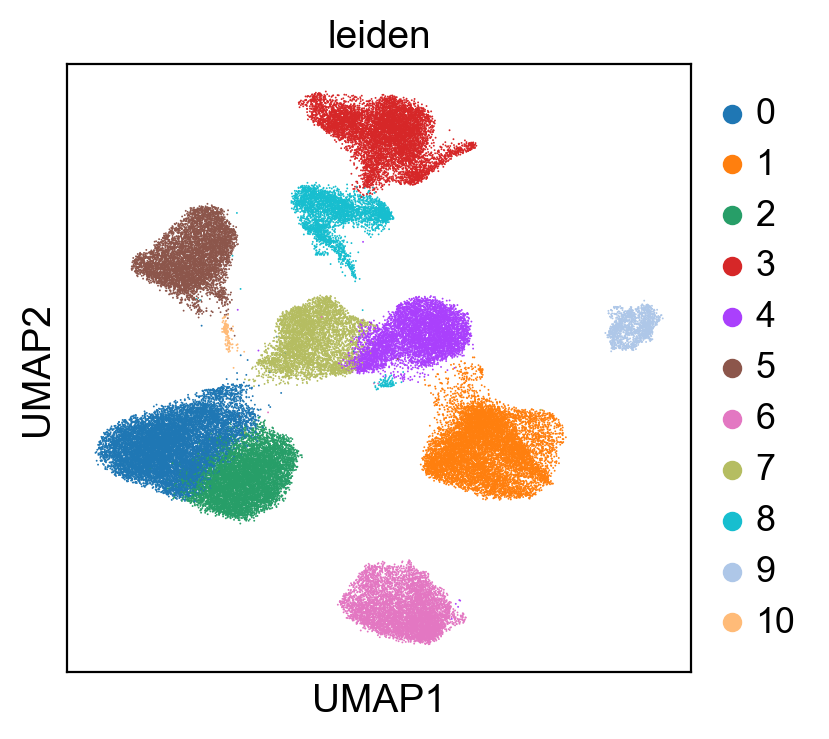

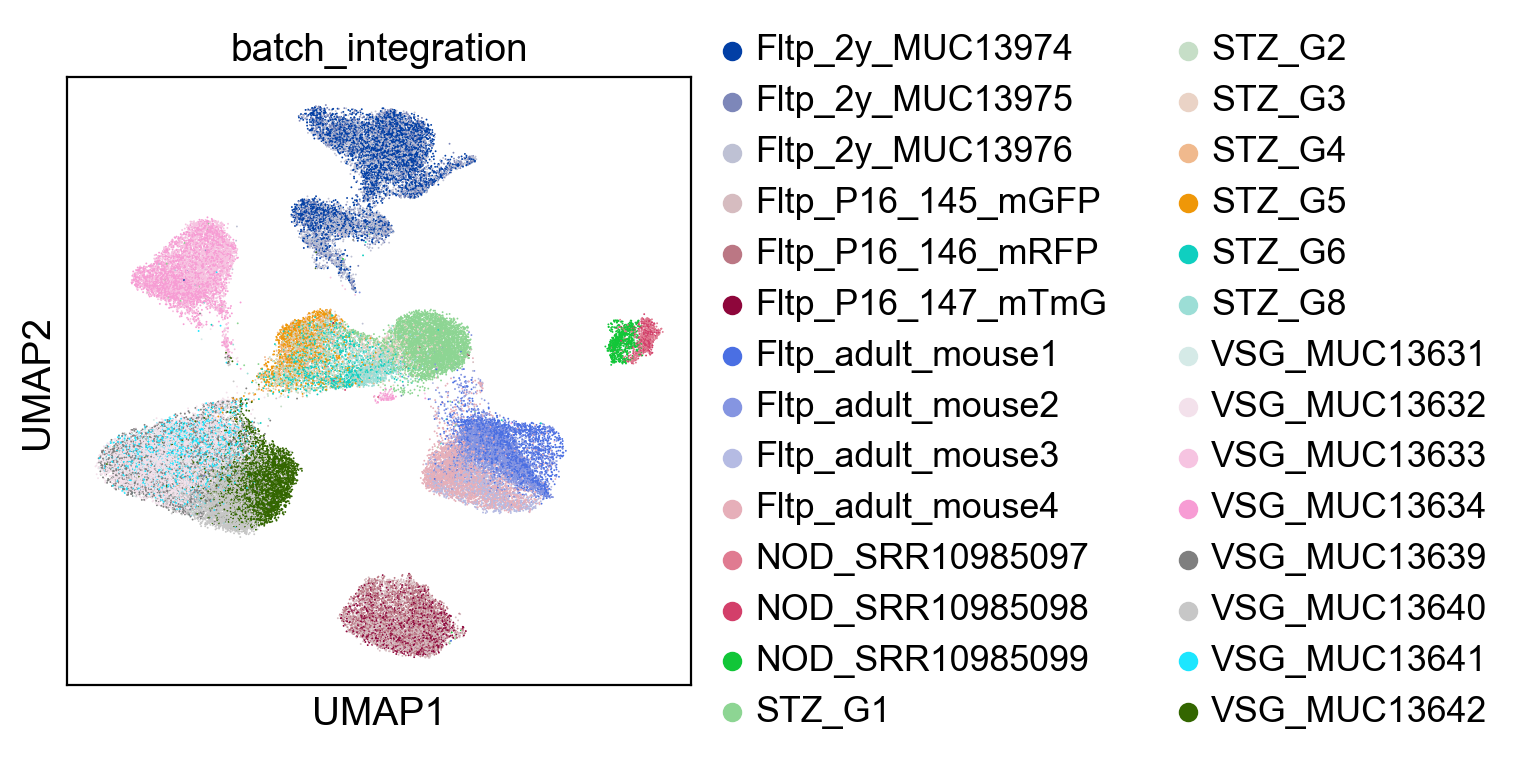

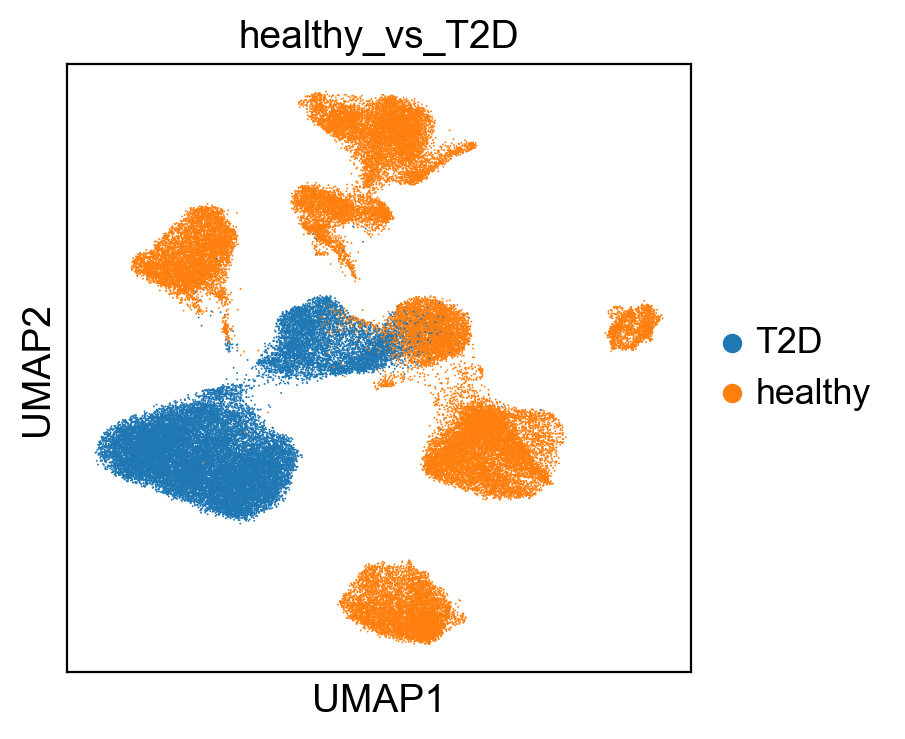

In [25]:
# visualise

beta.uns.pop('leiden_colors', None)
n_clust = beta.obs['leiden'].nunique()


sc.pl.umap(beta, color=['leiden'])
sc.pl.umap(beta, color=['batch_integration'])
sc.pl.umap(beta, color=['healthy_vs_T2D'])

## Run DE: T2D vs Healthy (Wilcoxon)

In [26]:

# Ensure neighborhood graph (not strictly required for DE, but allows quick UMAP viz)
if 'neighbors' not in beta.uns:
    sc.pp.neighbors(beta, n_neighbors=15, n_pcs=min(30, beta.n_vars-1))
    sc.tl.umap(beta)

sc.tl.rank_genes_groups(
    beta, groupby='healthy_vs_T2D',
    groups=['T2D'], reference='healthy',
    method='wilcoxon', use_raw=False
)
de_t2d = sc.get.rank_genes_groups_df(beta, group='T2D')
de_t2d = de_t2d.rename(columns={'names':'gene','logfoldchanges':'logFC','pvals_adj':'padj'})
de_t2d.to_csv(OUT/'DE_beta_T2D_vs_healthy.csv', index=False)
de_t2d.head(10)


ranking genes
    finished (0:00:03)


,gene,scores,logFC,pvals,padj
0,ENSMUSG00000032181,184.823303,1.441008,0.0,0.0
1,ENSMUSG00000026335,184.770660,2.177248,0.0,0.0
2,ENSMUSG00000035540,181.565750,3.922267,0.0,0.0
3,ENSMUSG00000050711,181.019241,1.308015,0.0,0.0
4,ENSMUSG00000003355,176.423050,2.382191,0.0,0.0
5,ENSMUSG00000015401,176.222778,1.756496,0.0,0.0
6,ENSMUSG00000023236,168.876450,1.201222,0.0,0.0
7,ENSMUSG00000018451,158.921616,3.403561,0.0,0.0
8,ENSMUSG00000026989,153.998642,2.996395,0.0,0.0
9,ENSMUSG00000032532,151.588974,10.102641,0.0,0.0


## Volcano plot

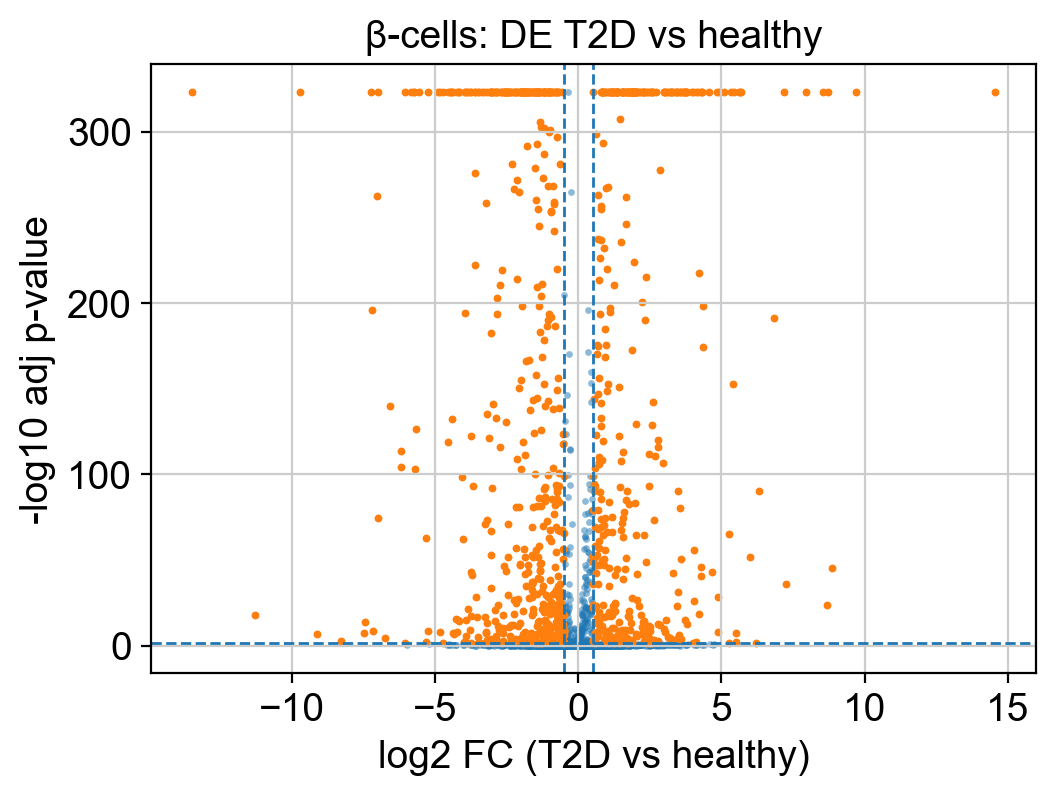

In [27]:

df = de_t2d.copy()
# Use log2 FC for interpretability
df['log2FC'] = df['logFC'] / np.log(2)
df['neglog10_padj'] = -np.log10(df['padj'].replace(0, np.nextafter(0,1)))

sig = (df['padj'] < 0.05) & (df['log2FC'].abs() > 0.5)
fig, ax = plt.subplots(figsize=(5.5,4.2))
ax.scatter(df['log2FC'], df['neglog10_padj'], s=6, alpha=0.5, linewidths=0)
ax.scatter(df.loc[sig,'log2FC'], df.loc[sig,'neglog10_padj'], s=8, linewidths=0)

ax.axvline( 0.5, ls='--', lw=1); ax.axvline(-0.5, ls='--', lw=1)
ax.axhline(-np.log10(0.05), ls='--', lw=1)
ax.set_xlabel('log2 FC (T2D vs healthy)')
ax.set_ylabel('-log10 adj p-value')
ax.set_title('β-cells: DE T2D vs healthy')

# label a few well-known genes if present
highlight = ['MAFA','NKX6-1','PDX1','UCN3','SLC2A2','G6PC2','HSPA5','DDIT3','DNAJC3','HERPUD1']
highlight = [g for g in highlight if g in df['gene'].values or g.capitalize() in df['gene'].values]
for g in highlight:
    row = df.loc[df['gene'].str.lower()==g.lower()]
    if len(row):
        x = row['log2FC'].values[0]; y = row['neglog10_padj'].values[0]
        ax.text(x, y, g, fontsize=8)
plt.tight_layout(); plt.show()


## GO Biological Process enrichment (up- and down-regulated)

In [28]:
%pip install "gseapy<1.1"

Note: you may need to restart the kernel to use updated packages.


In [29]:
import gseapy as gp
libs = gp.get_library_name()        # returns a list
print([l for l in libs if 'Mouse' in l][:10])   # first few mouse libs

['HDSigDB_Mouse_2021', 'JASPAR_PWM_Mouse_2025', 'KEGG_2019_Mouse', 'KOMP2_Mouse_Phenotypes_2022', 'Mouse_Gene_Atlas', 'PerturbAtlas_MouseGenePerturbationSigs', 'WikiPathways_2019_Mouse', 'WikiPathways_2024_Mouse']


Note: you may need to restart the kernel to use updated packages.


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Mapped: 919 Ensembl IDs → symbols
Up genes  (symbols): 400
Down genes(symbols): 519
Rows returned  UP : 234
Rows returned DOWN: 263


/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


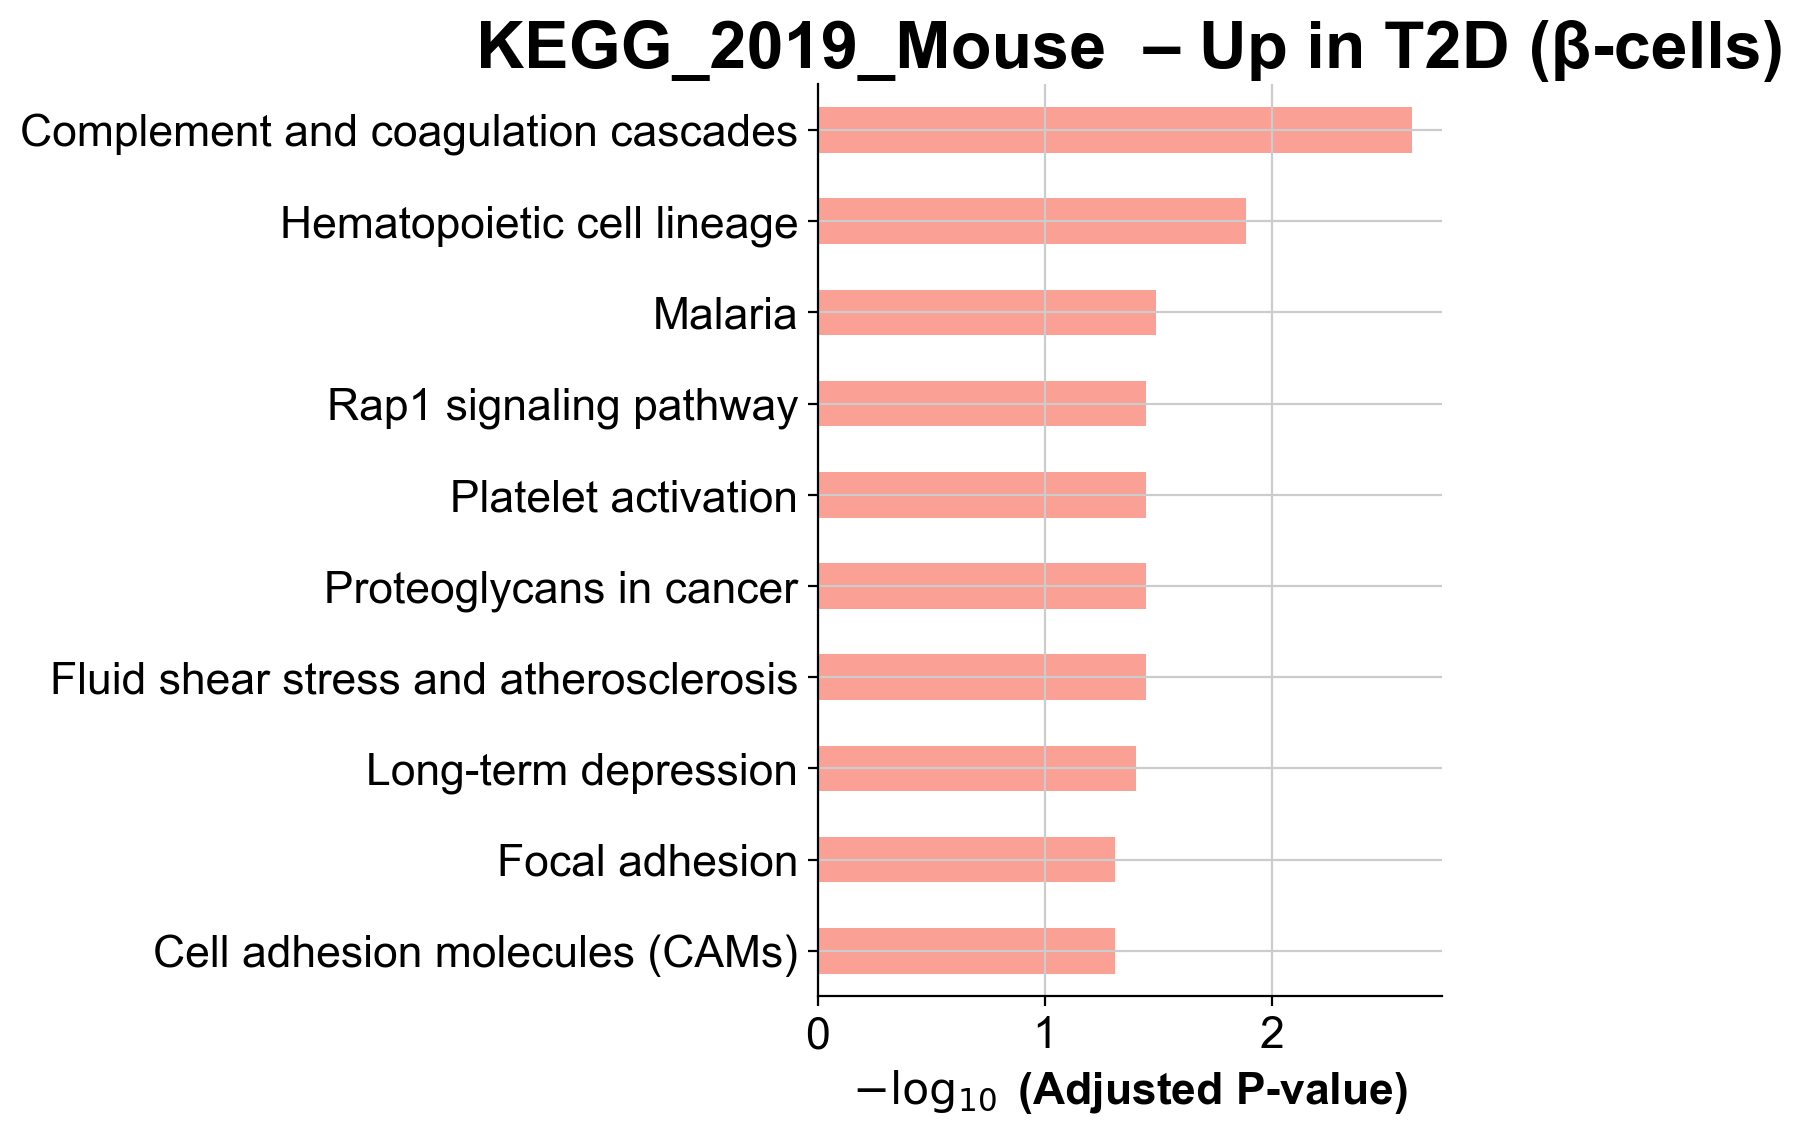

/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/opt/anaconda3/envs/pancreas_atlas/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


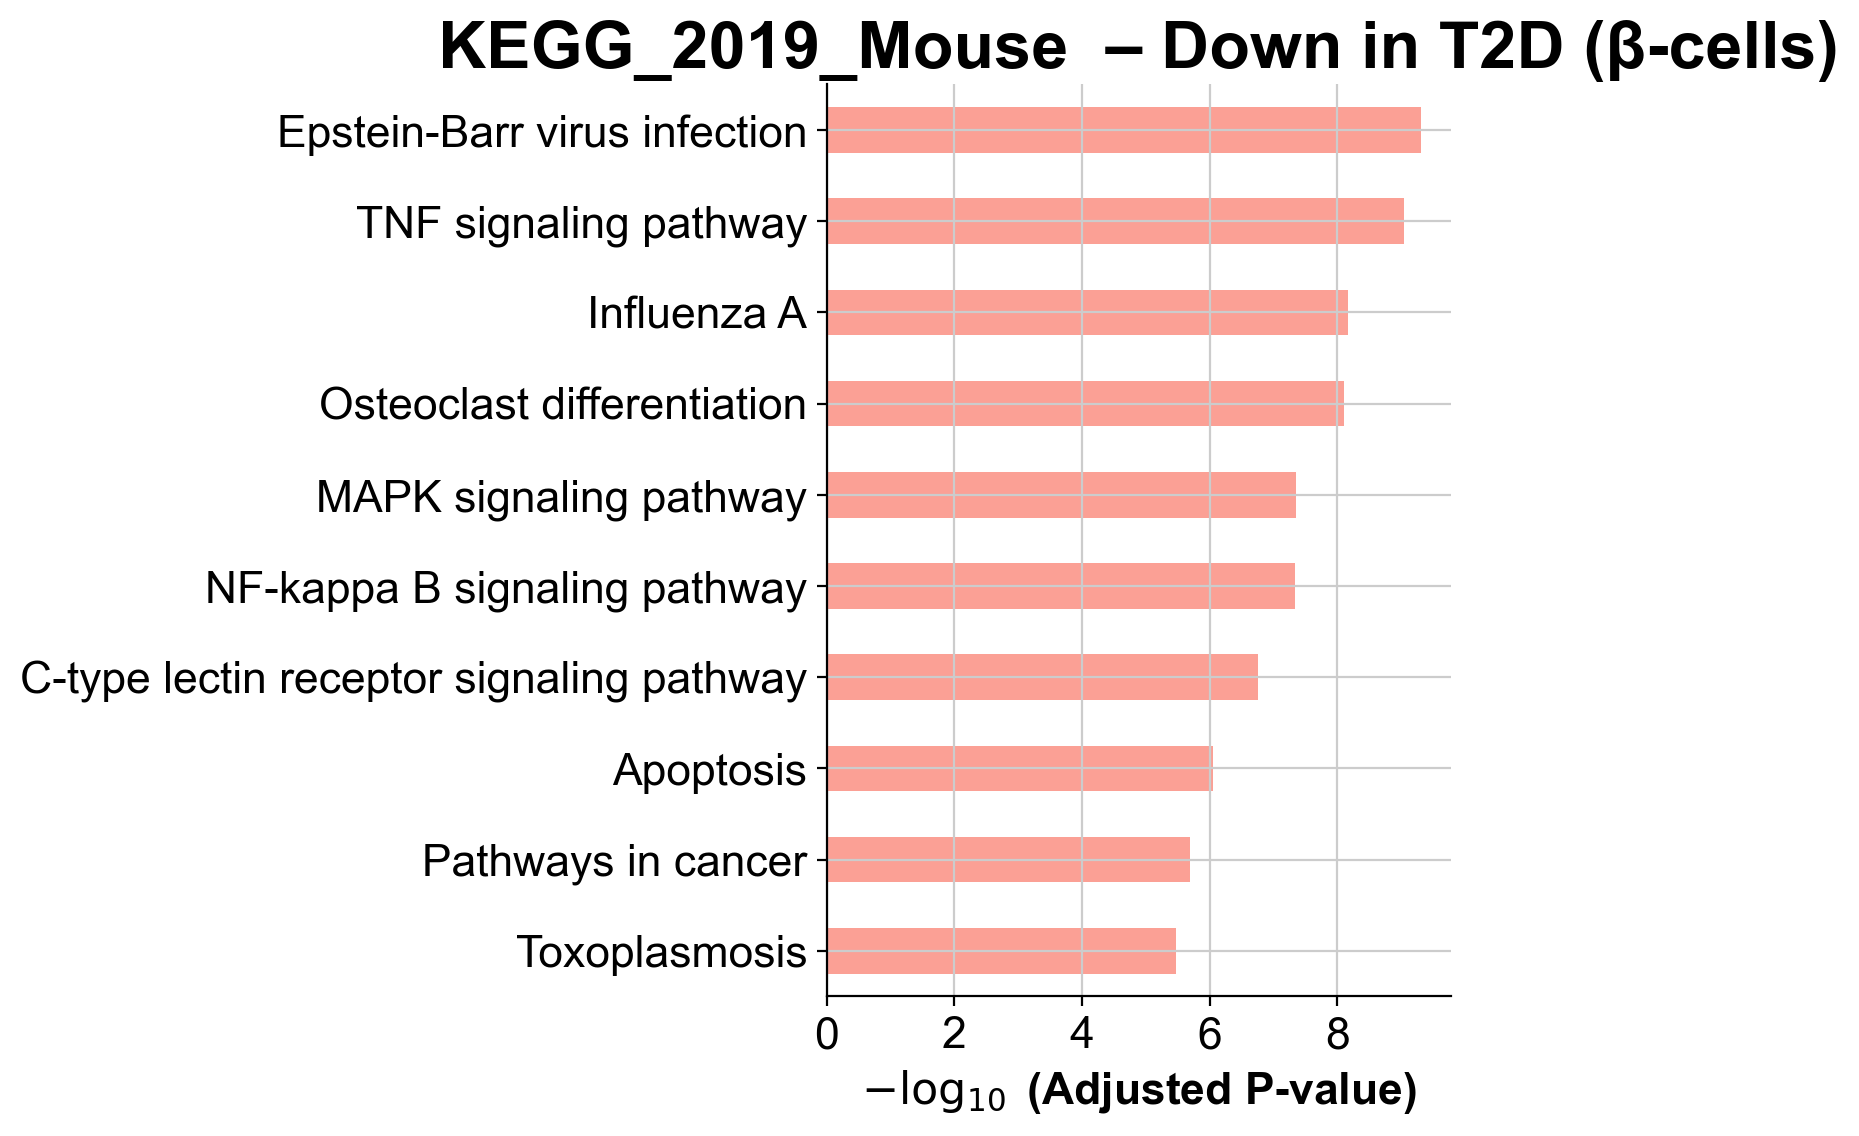

In [30]:
# 0) one-off: install mygene for ID-mapping (tiny dependency)
%pip install -q mygene

# 1) map Ensembl IDs → official symbols (mouse)
import mygene
mg = mygene.MyGeneInfo()

def ensembl_to_symbol(ids):
    """Return a dict {ensembl_id: symbol}  (drops unmapped)."""
    # strip version numbers if present
    clean_ids = [i.split('.')[0] for i in ids]
    out = mg.querymany(clean_ids, scopes='ensembl.gene',
                       fields='symbol', species='mouse', as_dataframe=True)
    out = out[['symbol']].dropna()
    return out['symbol'].to_dict()

# --- build gene lists ------------------------------------------------
up_ids   = df.query('padj < 0.05 and log2FC >  0.5')['gene'].tolist()
down_ids = df.query('padj < 0.05 and log2FC < -0.5')['gene'].tolist()

id2sym = ensembl_to_symbol(set(up_ids + down_ids))
up_genes   = [id2sym[i.split('.')[0]] for i in up_ids   if i.split('.')[0] in id2sym]
down_genes = [id2sym[i.split('.')[0]] for i in down_ids if i.split('.')[0] in id2sym]

print(f"Mapped: {len(id2sym)} Ensembl IDs → symbols")
print(f"Up genes  (symbols): {len(up_genes)}")
print(f"Down genes(symbols): {len(down_genes)}")

# 2) run Enrichr   (mouse-specific library or GO)
LIB = "KEGG_2019_Mouse"          # pick any library in gp.get_library_name()
enr_up   = gp.enrichr(gene_list=up_genes,   gene_sets=[LIB],
                      organism='Mouse', outdir=None, verbose=False)
enr_down = gp.enrichr(gene_list=down_genes, gene_sets=[LIB],
                      organism='Mouse', outdir=None, verbose=False)

print("Rows returned  UP :", len(enr_up.results))
print("Rows returned DOWN:", len(enr_down.results))

# 3) bar-plot if we got hits
def barplot(res, title, n=15):
    top = res.sort_values('Adjusted P-value').head(n)
    ax = gp.barplot(top, title=title, cutoff=0.05, ofname=None)
    plt.show()

if not enr_up.results.empty:
    barplot(enr_up.results,  f'{LIB}  – Up in T2D (β-cells)')
if not enr_down.results.empty:
    barplot(enr_down.results,f'{LIB}  – Down in T2D (β-cells)')

## Save processed object

In [31]:
#  Save filtered object + quick summary for downstream ML work
OUTFILE = PROCESSED_DATA_DIR / "mouse_atlas_filtered_ML.h5ad"

# 1) write to disk
beta.write(OUTFILE, compression="gzip")
print(f"\ Saved AnnData to: {OUTFILE.resolve()!s}")

# 2) summary statistics -------------------------------------------------
print("\n=== Saved object summary ===")
print(f" • Cells (n_obs):  {beta.n_obs:,}")
print(f" • Genes (n_vars): {beta.n_vars:,}")

# 3) inspect labels (categorical columns) ------------------------------
cat_cols = [c for c in beta.obs.columns if pd.api.types.is_categorical_dtype(beta.obs[c])]
print(f"\nCategorical labels in .obs ({len(cat_cols)}):")
for c in cat_cols:
    print(f"   - {c:25s}  ({beta.obs[c].nunique()} categories)")

# 4) inspect high-level metadata keys in .uns --------------------------
if beta.uns:
    print(f"\nTop-level .uns keys ({len(beta.uns)}):")
    for k in beta.uns.keys():
        print(f"   • {k}")
else:
    print("\nNo additional metadata stored in .uns")

\ Saved AnnData to: /Users/mdelaluz/Documents/GitHub/t2d-gene-disease-ml-prediction/data/processed/mouse_atlas_filtered_ML.h5ad

=== Saved object summary ===
 • Cells (n_obs):  65,582
 • Genes (n_vars): 1,997

Categorical labels in .obs (44):
   - batch_integration          (28 categories)
   - dataset                    (6 categories)
   - design                     (20 categories)
   - cell_cycle_phase           (3 categories)
   - cell_filtering             (4 categories)
   - strain                     (7 categories)
   - age                        (6 categories)
   - cell_type_originalDataset_unified  (17 categories)
   - cell_type_originalDataset  (24 categories)
   - cell_type_reannotatedIntegrated  (1 categories)
   - dataset__design__sample    (28 categories)
   - cell_subtype_immune_reannotatedIntegrated  (0 categories)
   - cell_subtype_endothelial_reannotatedIntegrated  (0 categories)
   - cell_subtype_beta_coarse_reannotatedIntegrated  (9 categories)
   - cell_subtype_beta

/var/folders/19/d97czy951sb67yv3hd9974780000gn/T/ipykernel_78054/3367215683.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  cat_cols = [c for c in beta.obs.columns if pd.api.types.is_categorical_dtype(beta.obs[c])]
